# Homework 4 - FFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import scipy.linalg as l
from IPython.display import display, Math, Latex
from PIL import Image, ImageFilter
import os, os.path
import glob
from copy import deepcopy, copy

# Introduction:
We will be implementing the FFT on images and then comparing it to the DCT to compare speed.

# Method
We will first code the FFT and then implement the DCT and FFT with the same image and then compare the time it takes for both to finish.

In [2]:
def DFT(x):
    """Compute the 2D discrete Fourier Transform of the input image"""
    N = x.shape[0]
    M = x.shape[1]
    u = np.arange(N)
    ku = u.reshape((N, 1))
    v = np.arange(N)
    kv = v.reshape((M, 1))
    Mu = np.exp(-2j * np.pi * ku * u / N)
    Mv = np.exp(-2j * np.pi * kv * v / N)
    return np.dot(np.dot(Mu, x),Mv)

In [3]:

def FFT2d(x):
    """Recursive 2D FFT"""
    #x = np.asarray(x, dtype=float)
    N = x.shape[0]
    M = x.shape[1]
    N2 = int(N/2)
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
        
    elif N <= 128:  # this cutoff should be optimized
        return DFT(x)
    
    else:
        X_even_even = DFT(x[::2,::2])

        X_odd_even = DFT(x[::2,1::2])
        
        X_even_odd = DFT(x[1::2,::2])
        
        X_odd_odd = DFT(x[1::2,1::2])
        
        factor_u = np.exp(-2j * np.pi * np.arange(N) / N)
        factor_v = np.exp(-2j * np.pi * np.arange(N) / N)
        
        first_quadrant = X_even_even + (np.reshape(factor_v[:N2],(N2,1)) * X_even_odd) + (X_odd_even * factor_u[:N2]) + (np.reshape(factor_v[:N2],(N2,1)) * factor_u[:N2] * X_odd_odd)
        second_quadrant = X_even_even + (np.reshape(factor_v[:N2],(N2,1)) * X_even_odd) + (X_odd_even * factor_u[N2:]) + (np.reshape(factor_v[:N2],(N2,1)) * factor_u[N2:] * X_odd_odd)
        third_quadrant = X_even_even + (np.reshape(factor_v[N2:],(N2,1)) * X_even_odd) + (X_odd_even * factor_u[:N2]) + (np.reshape(factor_v[N2:],(N2,1)) * factor_u[:N2] * X_odd_odd)
        fourth_quadrant = X_even_even + (np.reshape(factor_v[N2:],(N2,1)) * X_even_odd) + (X_odd_even * factor_u[N2:]) + (np.reshape(factor_v[N2:],(N2,1)) * factor_u[N2:] * X_odd_odd)
        
        ret1 = np.append(first_quadrant,second_quadrant,axis=1)
        ret2 = np.append(third_quadrant,fourth_quadrant,axis=1)
        return np.append(ret1,ret2,axis=0)

In [4]:
# Image resizing
def average_channel(channel):
    ret = []
    #print(channel.shape)
    for i in range(0,channel.shape[0],2):
        img_row = []
        for j in range(0,channel.shape[1],2):
            #print(channel[i][j])
            #print(channel[i+1][j])
            #print(channel[i][j+1])
            #print(channel[i+1][j+1])
            avg = int(channel[i][j]) + int(channel[i+1][j]) + int(channel[i][j+1]) + int(channel[i+1][j+1])
            #print(avg)
            avg = avg/4
            img_row.append(np.uint8(avg))
        #print(img_row)
        ret.append(img_row)
    
    return np.array(ret)

def reduce_image(image):
    if(len(image.shape) < 3):
        image = image.reshape(image.shape[0],image.shape[1],1)
    if(image.dtype == 'float32'):
        image = image*255
    
    width = image.shape[0]
    height = image.shape[1]
    channels = image.shape[2]
    #print(image.shape[0])
    if((width%2) == 1):
        image = image[:-1,:,:]
        #print(image.shape[0])
        width-=1
        
    if((height%2) == 1):
        image = image[:,:-1,:]
        #print(image.shape[0])
        height-=1
        
    #plt.imshow(image,cmap='gray')
    #plt.show()
    if(channels > 1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,1],(width,height))
        blue = np.reshape(image[...,2],(width,height))
    elif(channels==1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,0],(width,height))
        blue = np.reshape(image[...,0],(width,height))
    else:
        raise Exception("Invalid image channels")
        
    average_red = average_channel(red)
    #average_green = average_channel(green)
    #average_blue = average_channel(blue)
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_green,(average_green.shape[0],average_green.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_blue,(average_blue.shape[0],average_blue.shape[1],1)),axis=-1)
    return average_red#ret
    
def display_DFT(computed_DFT):
    return np.sqrt(np.square(computed_DFT[0])  +  np.square(computed_DFT[1]))
def scale_display(disp):
    maximum = np.max(disp)
    return ((255/np.log10(255))*np.log10(1+(255/maximum)*disp)).astype('int32')
def scale_display_2(disp):
    return 20*np.log10(disp)/np.log10(8)

In [5]:
ima = []
for filename in glob.glob('imagesHW2/64x64/*.jpg'): #assuming gif
    img = plt.imread(filename)
    ima.append(img)

In [6]:
transformed = FFT2d(img)

In [7]:
back = FFT2d(transformed)

In [8]:
bb = back/512**2

In [9]:
ddp = np.sqrt(transformed.real **2 + transformed.imag **2)

In [10]:
def show(o_img, fft):    
    fig = plt.figure()
    fig.set_figheight(25)
    fig.set_figwidth(25)

    fig.add_subplot(1,2,1)
    plt.imshow(o_img, cmap='gray')

    # display the new image
    fig.add_subplot(1,2,2)
    plt.imshow(fft, cmap='gray')

    

    plt.show(block=True)

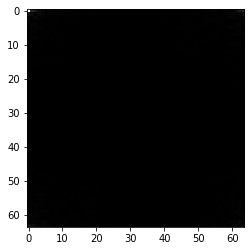

In [11]:
plt.imshow(ddp,cmap='gray')

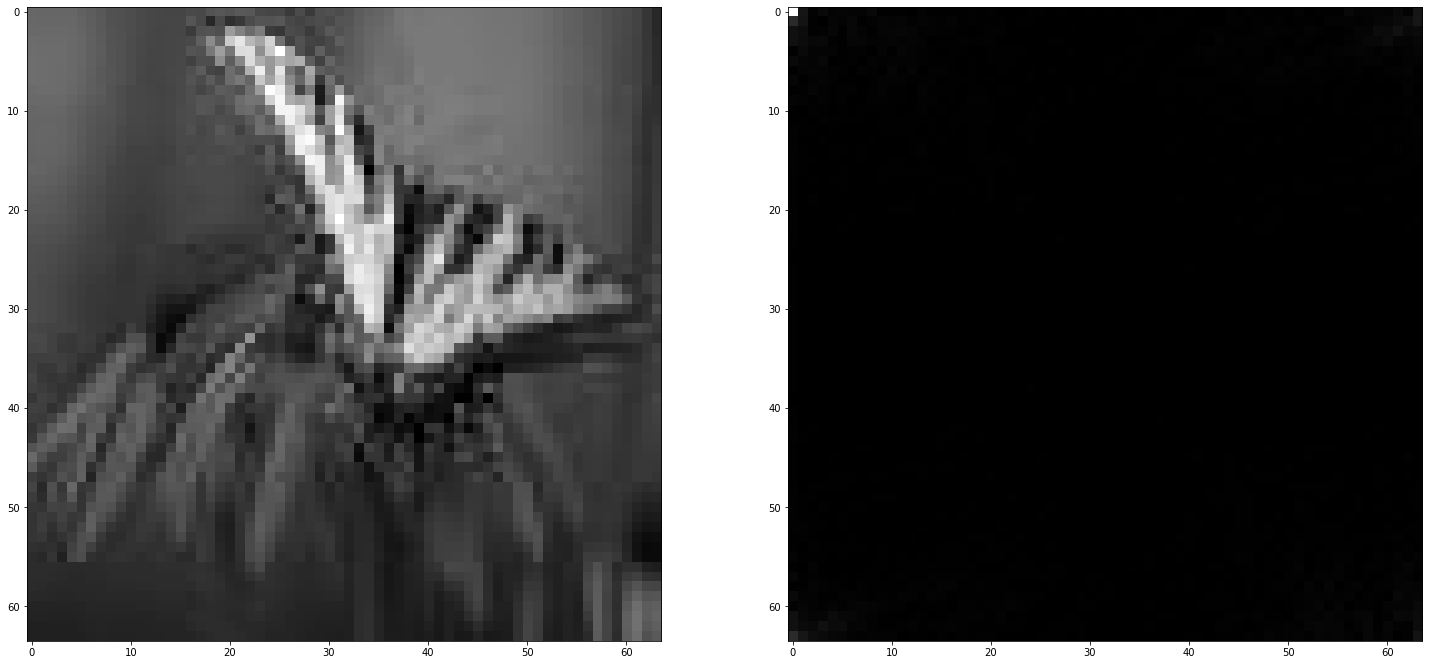

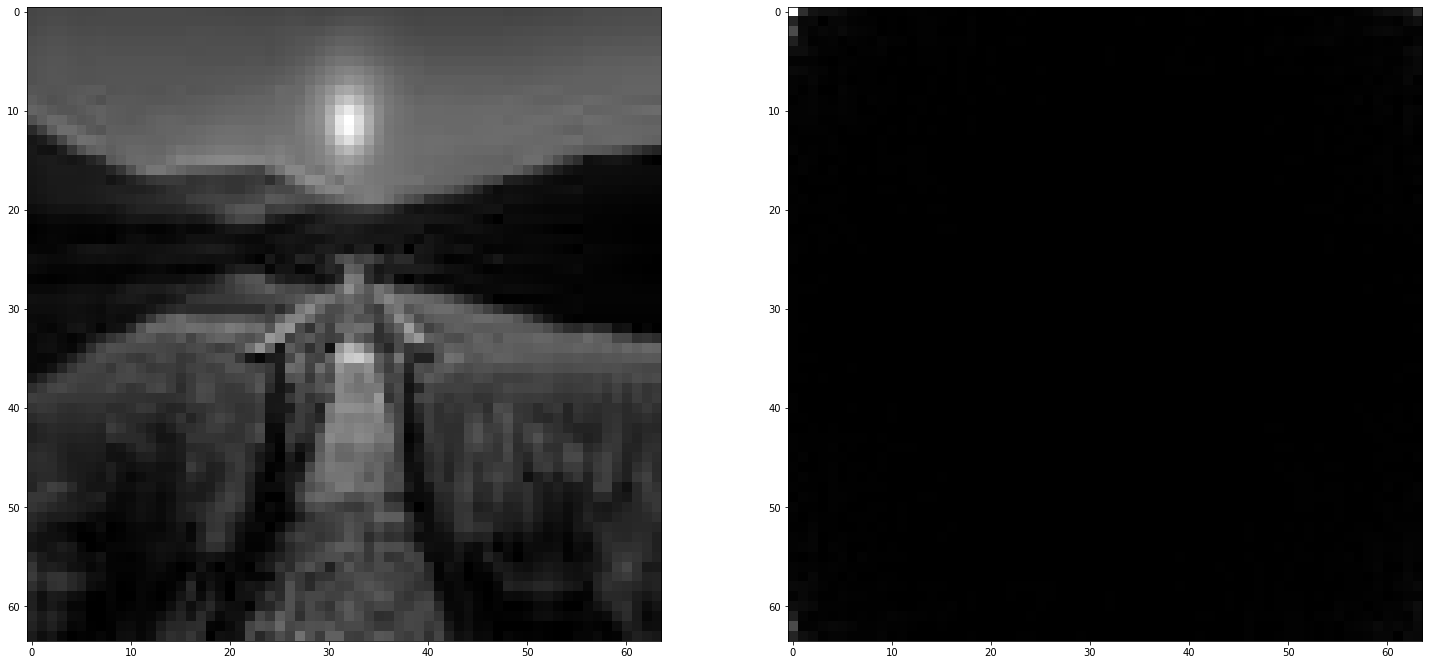

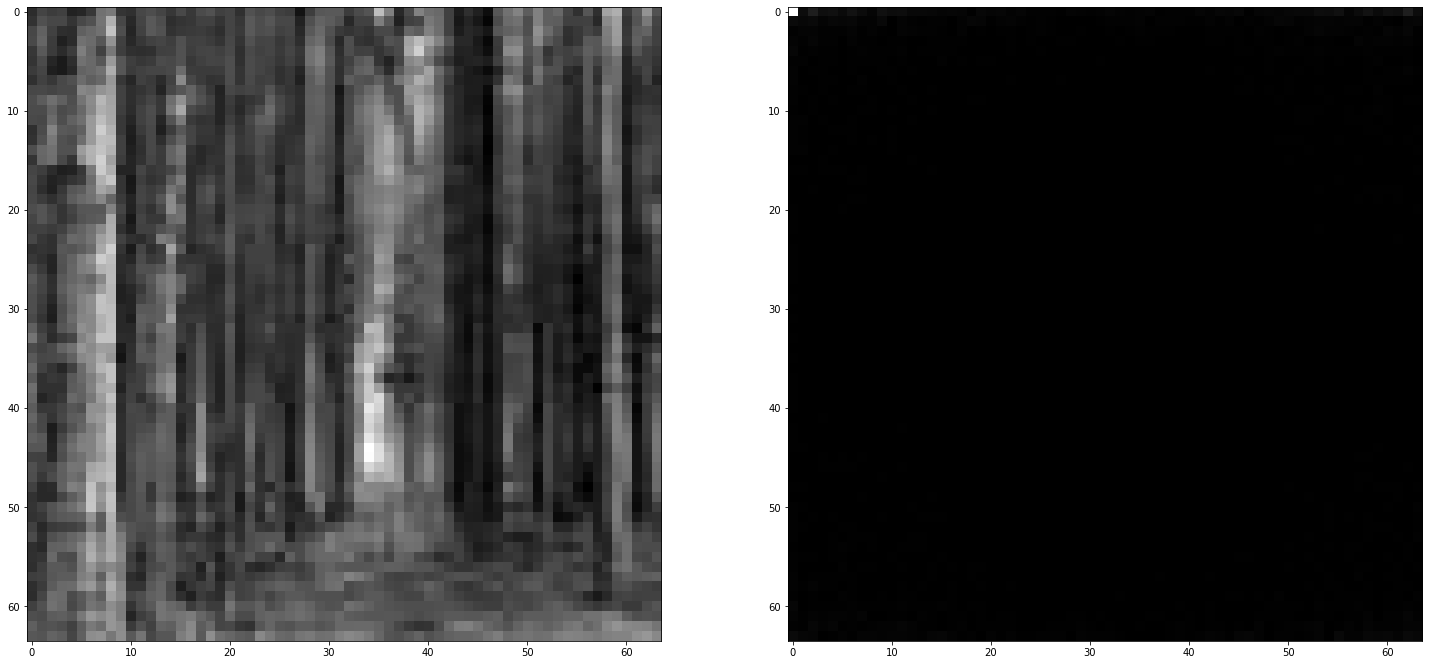

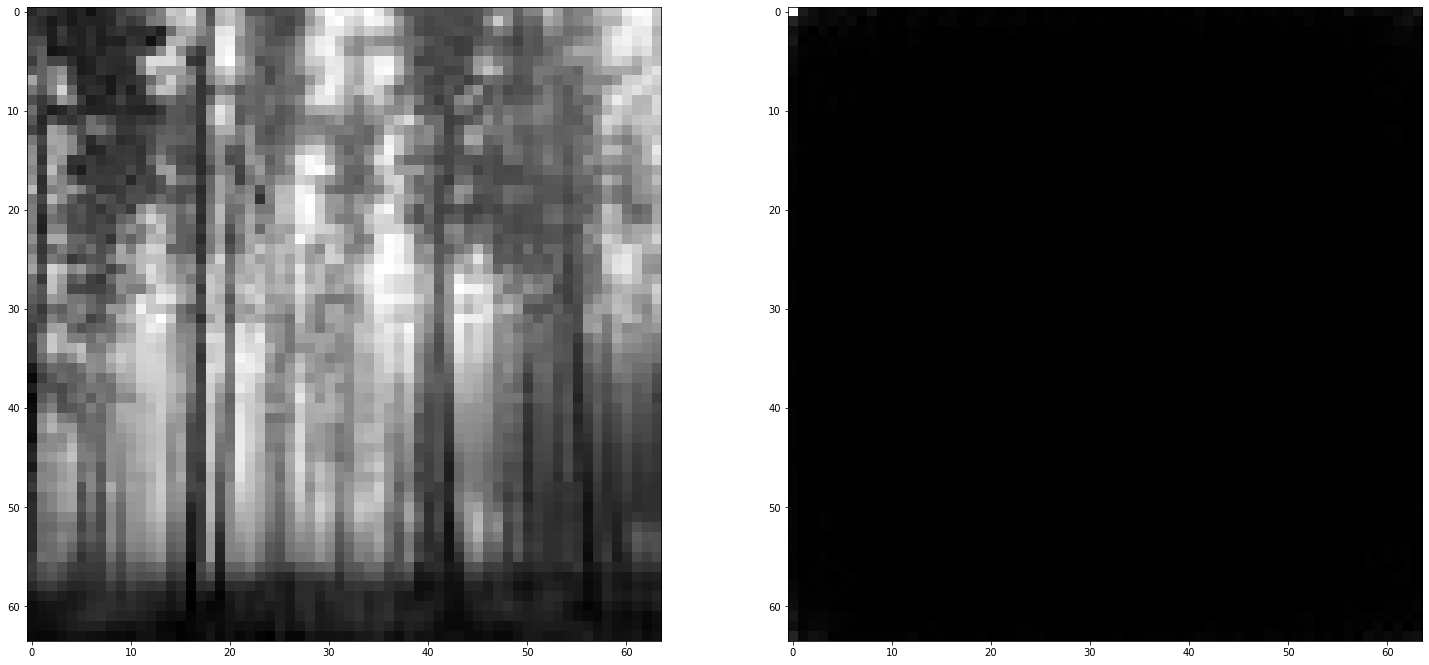

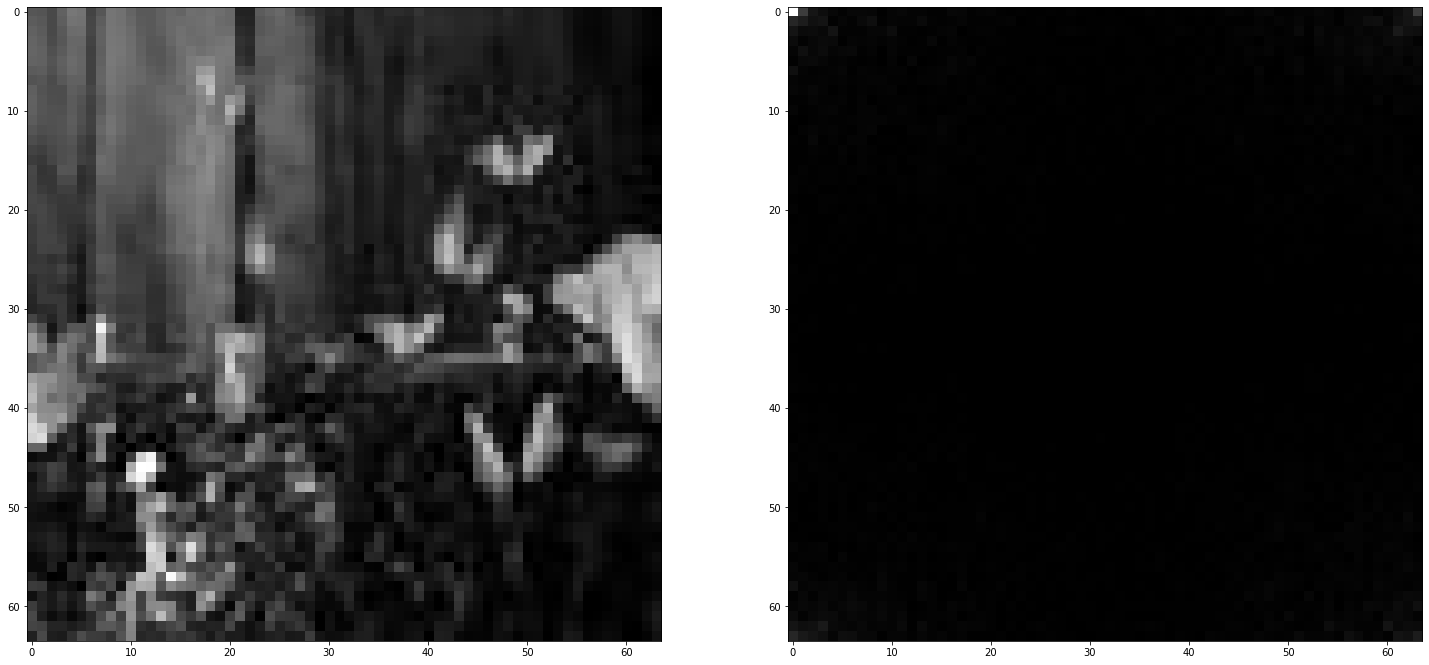

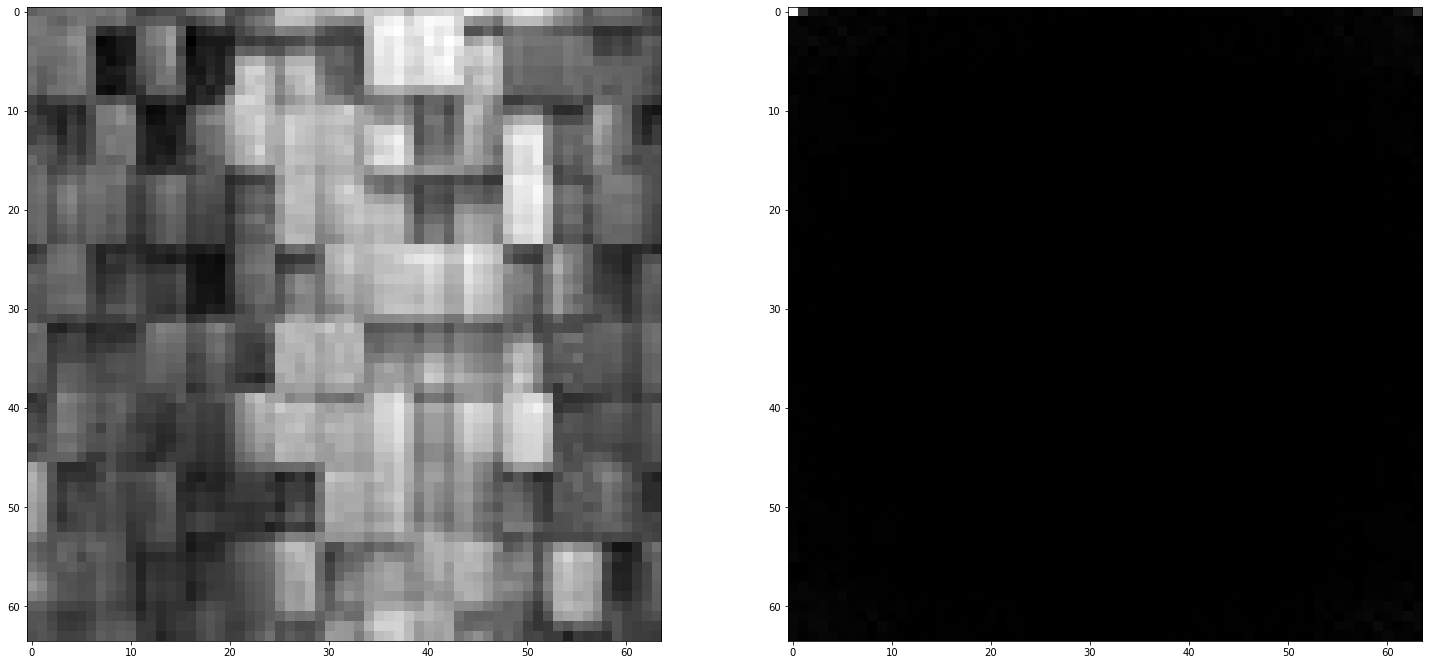

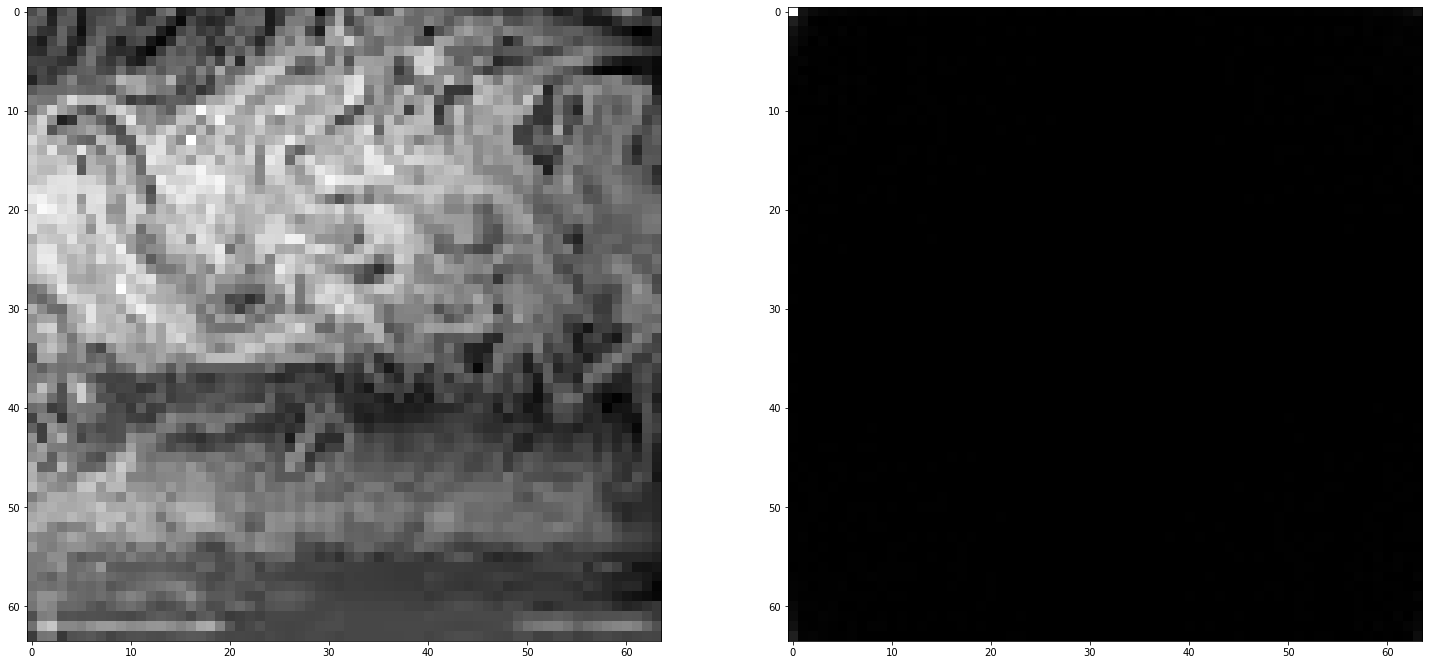

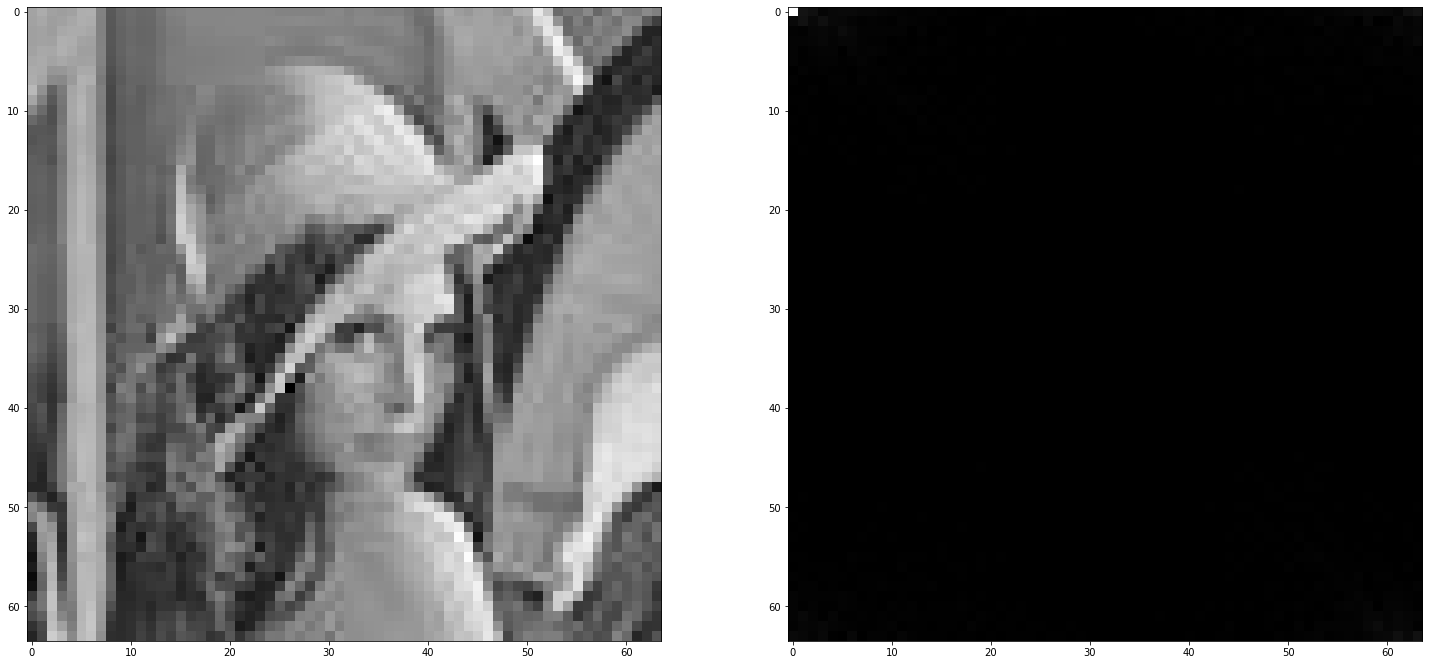

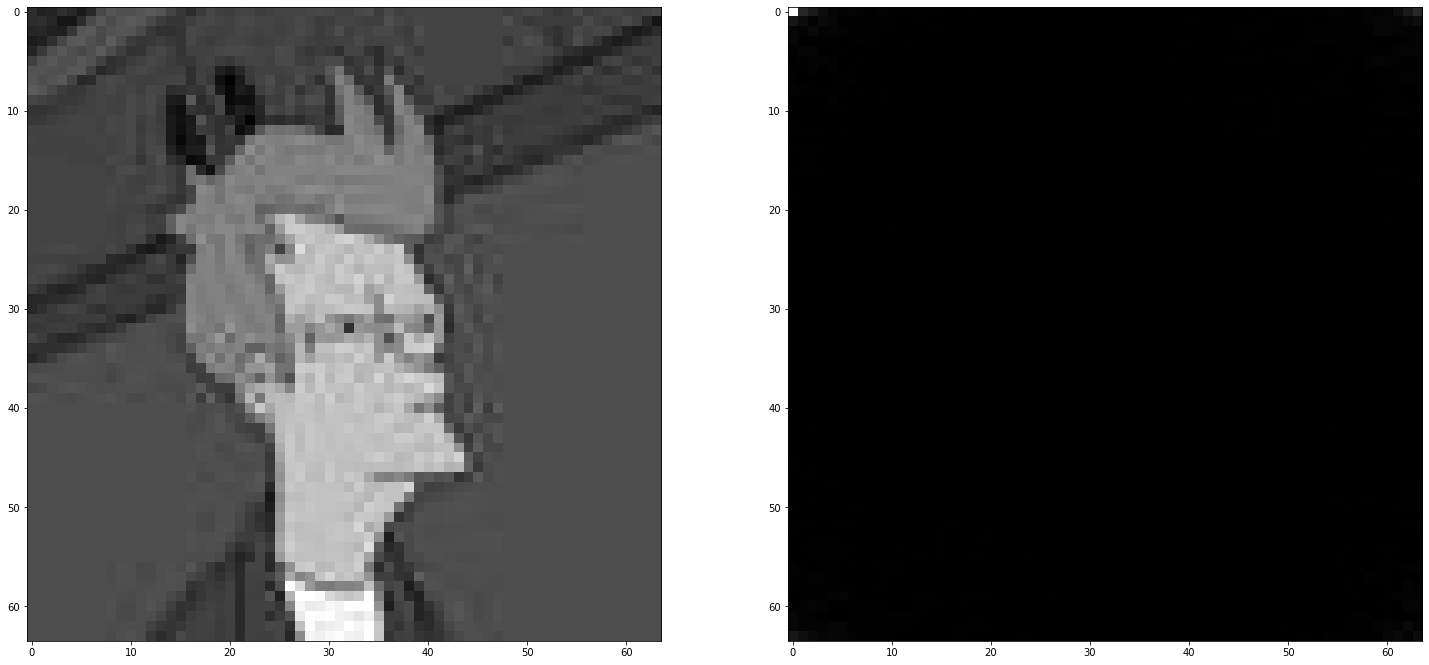

In [12]:
for i in range(len(ima)):
    transformed = FFT2d(ima[i])
    back = FFT2d(transformed)
    bb = back/512**2
    ddp = np.sqrt(transformed.real **2 + transformed.imag **2)
    
    show(ima[i], ddp)

In [13]:
# im = Image.open("imagesHW3/test.jpg")
# img = im.resize((4096,4096), Image.ANTIALIAS)
# img = img.convert("L")
# img.save("imagesHW3/test2.jpg") 

In [14]:
ima = []
for filename in glob.glob('imagesHW2/512x512/*.jpg'): #assuming gif
    img = plt.imread(filename)
    ima.append(img)

In [15]:
def plot_comparison(img):
    img_4096 = img
    img_2048 = reduce_image(img_4096)
    img_1028 = reduce_image(img_2048)
    img_512 = reduce_image(img_1028)
    img_256 = reduce_image(img_512)
    img_128 = reduce_image(img_256)
    img_64 = reduce_image(img_128)
    img_32 = reduce_image(img_64)
    
    time_fft = []
    time_dft = []
    
    '''Time taken by FFT'''
    t1 = time.time()
    FFT2d(img_32)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_64)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_128)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_256)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_512)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_1028)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_2048)
    t2 = time.time()
    time_fft.append(t2 - t1)
    
    t1 = time.time()
    FFT2d(img_4096)
    t2 = time.time()
    time_fft.append(t2 - t1)
    '''Time taken by DFT'''
    t1 = time.time()
    DFT(img_32)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_64)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_128)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_256)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_512)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_1028)
    t2 = time.time()
    time_dft.append(t2 - t1)

    t1 = time.time()
    DFT(img_2048)
    t2 = time.time()
    time_dft.append(t2 - t1)
    
    t1 = time.time()
    DFT(img_4096)
    t2 = time.time()
    time_dft.append(t2 - t1)

    return time_dft,time_fft

In [16]:
img_1 = plt.imread("imagesHW3/test2.jpg")

In [17]:
img_1.shape

(4096, 4096)

In [18]:
dft, fft=plot_comparison(img_1)

# Result:
Here we can see the speed difference of this two transform by using a 4096x4096 image

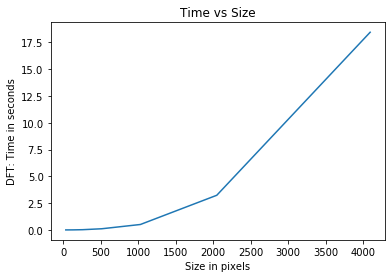

In [19]:
x = [32,64,128,256,512,1028,2048,4096]
plt.title("Time vs Size") 
plt.xlabel("Size in pixels") 
plt.ylabel("DFT: Time in seconds") 
plt.plot(x,dft) 
plt.show()

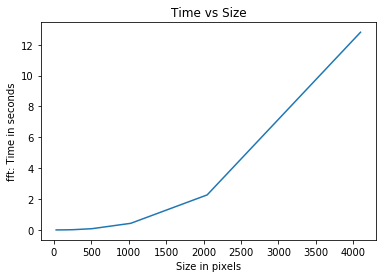

In [20]:
x = [32,64,128,256,512,1028,2048,4096]
plt.title("Time vs Size") 
plt.xlabel("Size in pixels") 
plt.ylabel("fft: Time in seconds") 
plt.plot(x,fft) 
plt.show()

# Conclusion
From the speed charts we can see that fft is slighty faster for the images we have. If we have bigger samples FFT would be the transform to perform since it will give better performance in general